### Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import librosa
from scipy import stats # Para skew e kurtosis
import matplotlib.pyplot as plt
import seaborn
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from cuml.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from cuml.ensemble import RandomForestClassifier
from tqdm import tqdm # Para barras de progresso


# Importe o utils.py original do mdeff/fma para a função load()
# (Certifique-se que o utils.py do mdeff/fma esteja no seu diretório)
import utils 

### Audio Preprocessing

In [2]:

# --- Configuração ---
METADATA_DIR = '../fma_metadata'
AUDIO_DIR_GENRES = '../fma_datasets/fma_small_genres' # Este é o novo diretório que seu script 'reorganize_audio_into_genres.py' criou
FEATURE_FILE_X = '../preprocessed_features/fma_small_windowed_X_518.npy' # Arquivo para salvar features
FEATURE_FILE_y = '../preprocessed_features/fma_small_windowed_y_518.npy'
FEATURE_FILE_splits = '../preprocessed_features/fma_small_windowed_splits_518.npy'

# --- Carregar Metadados ---
## Carrega tracks.csv 
tracks = utils.load(f'{METADATA_DIR}/tracks.csv')

small_mask = tracks[('set', 'subset')] == 'small'
y_all_labels = tracks.loc[small_mask, ('track', 'genre_top')]
splits = tracks.loc[small_mask, ('set', 'split')]

label_encoder = LabelEncoder()
y_all_encoded = label_encoder.fit_transform(y_all_labels)

track_metadata = pd.DataFrame({
    'genre_top': y_all_labels,
    'genre_encoded': y_all_encoded,
    'split': splits
}, index=y_all_labels.index)

print(f"Metadados carregados para {track_metadata.shape[0]} faixas 'small'.")
print(f"Gêneros: {label_encoder.classes_}")

Metadados carregados para 8000 faixas 'small'.
Gêneros: ['Electronic' 'Experimental' 'Folk' 'Hip-Hop' 'Instrumental'
 'International' 'Pop' 'Rock']


In [3]:
def calculate_stats(features_matrix):
    """
    Calcula as 7 estatísticas (mean, std, skew, kurtosis, median, min, max) 
    exigidas pelo features.py.
    """
    result = []
    
    # Garantir que a matriz não esteja vazia
    if features_matrix.size == 0:
        # Retorna um vetor de zeros com o tamanho esperado (N_features * 7 stats)
        # O chamador precisa saber o N_features esperado
        return None 

    # 1. mean
    result.extend(np.mean(features_matrix, axis=1))
    # 2. std
    result.extend(np.std(features_matrix, axis=1))
    # 3. skew
    result.extend(stats.skew(features_matrix, axis=1))
    # 4. kurtosis
    result.extend(stats.kurtosis(features_matrix, axis=1))
    # 5. median
    result.extend(np.median(features_matrix, axis=1))
    # 6. min
    result.extend(np.min(features_matrix, axis=1))
    # 7. max
    result.extend(np.max(features_matrix, axis=1))
    
    return np.array(result)

def extract_features_windowed_full(file_path, window_size_sec=3, sr=22050):
    """
    Extrai o conjunto completo de 518 features para cada janela de 3s.
    Esta função é uma adaptação de 'compute_features' de features.py.
    """
    
    all_window_features = []
    
    # Parâmetros do librosa (como em features.py e baselines.ipynb)
    N_FFT = 2048
    HOP_LENGTH = 512
    N_MFCC = 20
    N_CHROMA = 12
    N_CONTRAST = 7 # 6 bandas + 1 (em features.py é 7)
    N_TONNETZ = 6
    
    try:
        y, sr_loaded = librosa.load(file_path, mono=True, sr=sr, res_type='kaiser_fast')
        
        samples_per_window = window_size_sec * sr
        n_windows = int(np.floor(len(y) / samples_per_window))
        
        for w in range(n_windows):
            start = w * samples_per_window
            end = start + samples_per_window
            y_window = y[start:end]
            
            # STFT e CQT (bases para muitas features)
            #
            stft = np.abs(librosa.stft(y_window, n_fft=N_FFT, hop_length=HOP_LENGTH))
            cqt = np.abs(librosa.cqt(y_window, sr=sr, hop_length=HOP_LENGTH))
            
            window_vector = [] # O vetor final de 518 features para esta janela
            
            # 1. ZCR (1 * 7 = 7 features)
            #
            f = librosa.feature.zero_crossing_rate(y_window, frame_length=N_FFT, hop_length=HOP_LENGTH)
            window_vector.extend(calculate_stats(f))
            
            # 2. Chroma CQT (12 * 7 = 84 features)
            #
            f = librosa.feature.chroma_cqt(C=cqt, n_chroma=N_CHROMA)
            window_vector.extend(calculate_stats(f))

            # 3. Chroma CENS (12 * 7 = 84 features)
            #
            f = librosa.feature.chroma_cens(C=cqt, n_chroma=N_CHROMA)
            window_vector.extend(calculate_stats(f))
            
            # 4. Chroma STFT (12 * 7 = 84 features)
            #
            f = librosa.feature.chroma_stft(S=stft**2, n_chroma=N_CHROMA)
            window_vector.extend(calculate_stats(f))
            
            # 5. RMSE (1 * 7 = 7 features)
            #
            f = librosa.feature.rms(S=stft) # Nota: features.py usa 'rmse', mas 'rms' é a função atual
            window_vector.extend(calculate_stats(f))

            # 6. Spectral Centroid (1 * 7 = 7 features)
            #
            f = librosa.feature.spectral_centroid(S=stft)
            window_vector.extend(calculate_stats(f))

            # 7. Spectral Bandwidth (1 * 7 = 7 features)
            #
            f = librosa.feature.spectral_bandwidth(S=stft)
            window_vector.extend(calculate_stats(f))

            # 8. Spectral Contrast (7 * 7 = 49 features)
            #
            f = librosa.feature.spectral_contrast(S=stft, n_bands=N_CONTRAST - 1)
            window_vector.extend(calculate_stats(f))

            # 9. Spectral Rolloff (1 * 7 = 7 features)
            #
            f = librosa.feature.spectral_rolloff(S=stft)
            window_vector.extend(calculate_stats(f))
            
            # 10. MFCC (20 * 7 = 140 features)
            #
            mel = librosa.feature.melspectrogram(S=stft**2, sr=sr)
            f = librosa.feature.mfcc(S=librosa.power_to_db(mel), n_mfcc=N_MFCC)
            window_vector.extend(calculate_stats(f))
            
            # 11. Tonnetz (6 * 7 = 42 features)
            #
            # (Calculado por último, pois pode depender do chroma_cens)
            f_chroma_cens = librosa.feature.chroma_cens(C=cqt, n_chroma=N_CHROMA) # Recalcula se necessário
            f = librosa.feature.tonnetz(y=librosa.effects.harmonic(y_window), sr=sr, chroma=f_chroma_cens)
            window_vector.extend(calculate_stats(f))
            
            # Adicionar o vetor completo (518 features)
            all_window_features.append(window_vector)
            
    except Exception as e:
        print(f"Erro ao processar {file_path}: {e}")
        
    return all_window_features

In [4]:
if not os.path.exists(FEATURE_FILE_X):
    print(f"Arquivos de features não encontrados. Iniciando extração (isso pode levar horas)...")
    
    all_features = []
    all_labels = []
    all_splits = []

    # Iterar sobre as 8000 faixas
    for track_id, row in tqdm(track_metadata.iterrows(), total=track_metadata.shape[0]):
        
        genre_top = row['genre_top']
        file_path = f"{AUDIO_DIR_GENRES}/{genre_top}/{track_id:06d}.mp3"
        
        if not os.path.exists(file_path):
            continue
            
        # Extrair a lista de vetores de 518 features
        #
        window_vectors = extract_features_windowed_full(file_path)
        
        # Adicionar cada janela como uma amostra separada
        for vec in window_vectors:
            # Garantir que o vetor não está corrompido (tamanho 518)
            if len(vec) == 518:
                all_features.append(vec)
                all_labels.append(row['genre_encoded'])
                all_splits.append(row['split'])

    # --- Criar os arrays finais ---
    X = np.array(all_features)
    y = np.array(all_labels)
    splits_array = np.array(all_splits)

    # --- SALVAR OS ARQUIVOS ---
    print(f"\nExtração concluída. Total de janelas: {X.shape[0]}. Features: {X.shape[1]}")
    print(f"Salvando features em {FEATURE_FILE_X}...")
    np.save(FEATURE_FILE_X, X)
    np.save(FEATURE_FILE_y, y)
    np.save(FEATURE_FILE_splits, splits_array)

else:
    print(f"Carregando features cacheadas de {FEATURE_FILE_X}...")
    X = np.load(FEATURE_FILE_X)
    y = np.load(FEATURE_FILE_y)
    splits_array = np.load(FEATURE_FILE_splits)
    print("Features carregadas.")
    print(f"Total de janelas: {X.shape[0]}. Features: {X.shape[1]}")

# Lidando com NaNs ou Infs que podem surgir da extração (skew/kurtosis)
X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)

Carregando features cacheadas de ../preprocessed_features/fma_small_windowed_X_518.npy...
Features carregadas.
Total de janelas: 75296. Features: 518


In [5]:
# --- Separar em Treino, Validação e Teste ---
train_mask = splits_array == 'training'
val_mask = splits_array == 'validation'
test_mask = splits_array == 'test'

X_train = X[train_mask]
y_train = y[train_mask]
X_val = X[val_mask]
y_val = y[val_mask]
X_test = X[test_mask]
y_test = y[test_mask]

print(f"\nAmostras de Treino: {X_train.shape[0]}")
print(f"Amostras de Validação: {X_val.shape[0]}")
print(f"Amostras de Teste: {X_test.shape[0]}")

# --- Normalizar as 518 Features ---
print("Normalizando features...")
scaler = StandardScaler()
scaler.fit(X_train) # Ajustar APENAS no treino

X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
print("Normalização concluída.")


Amostras de Treino: 60188
Amostras de Validação: 7544
Amostras de Teste: 7564
Normalizando features...
Normalização concluída.


### Treino dos Modelos


=== Treinando KNN (k=1) ===
--- Avaliando KNN (k=1) ---
Acurácia KNN (k=1) (por janela): 35.14%

Relatório de Classificação KNN (k=1):
               precision    recall  f1-score   support

   Electronic       0.54      0.27      0.36       943
 Experimental       0.30      0.09      0.14       942
         Folk       0.16      0.17      0.16       946
      Hip-Hop       0.42      0.82      0.56       941
 Instrumental       0.37      0.14      0.20       947
International       0.34      0.54      0.42       947
          Pop       0.27      0.13      0.17       951
         Rock       0.37      0.65      0.47       947

     accuracy                           0.35      7564
    macro avg       0.35      0.35      0.31      7564
 weighted avg       0.35      0.35      0.31      7564


Matriz de Confusão:


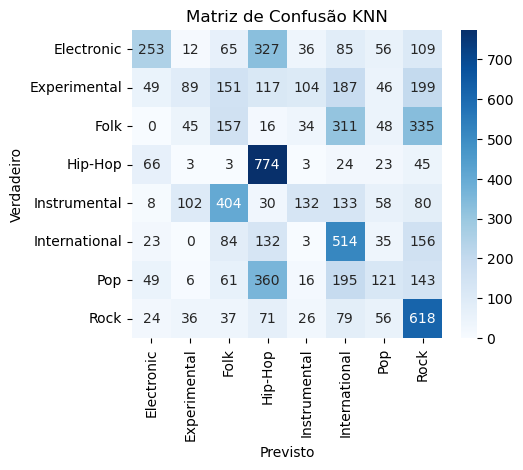


=== Treinando Random Forest ===
--- Avaliando Random Forest ---
Acurácia Random Forest (por janela): 39.44%

Relatório de Classificação Random Forest:
               precision    recall  f1-score   support

   Electronic       0.49      0.47      0.48       943
 Experimental       0.22      0.21      0.22       942
         Folk       0.21      0.27      0.24       946
      Hip-Hop       0.55      0.66      0.60       941
 Instrumental       0.36      0.33      0.34       947
International       0.47      0.47      0.47       947
          Pop       0.29      0.22      0.25       951
         Rock       0.55      0.52      0.54       947

     accuracy                           0.39      7564
    macro avg       0.39      0.39      0.39      7564
 weighted avg       0.39      0.39      0.39      7564


Matriz de Confusão:


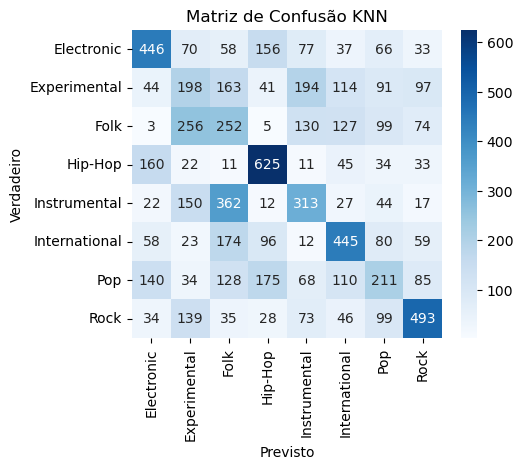


=== Treinando SVM (Linear) ===
--- Avaliando SVM (Linear) ---
Acurácia SVM (Linear) (por janela): 42.07%

Relatório de Classificação SVM (Linear):
               precision    recall  f1-score   support

   Electronic       0.53      0.60      0.56       943
 Experimental       0.28      0.27      0.28       942
         Folk       0.25      0.27      0.26       946
      Hip-Hop       0.65      0.72      0.68       941
 Instrumental       0.32      0.32      0.32       947
International       0.53      0.45      0.49       947
          Pop       0.30      0.30      0.30       951
         Rock       0.52      0.44      0.48       947

     accuracy                           0.42      7564
    macro avg       0.42      0.42      0.42      7564
 weighted avg       0.42      0.42      0.42      7564


Matriz de Confusão:


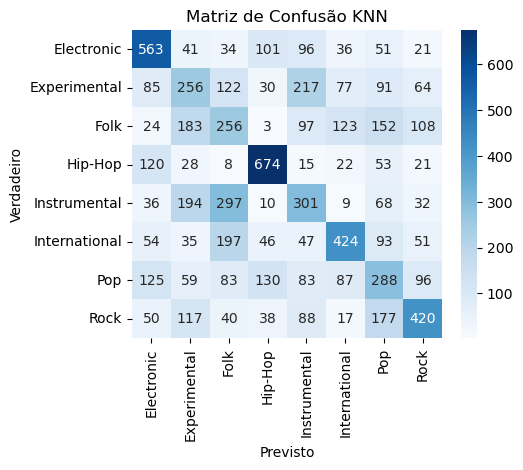

In [6]:
# --- Dicionário de Modelos ---
models = {
    "KNN (k=1)": KNeighborsClassifier(n_neighbors=85, n_jobs=-1),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=100, criterion="gini"),
    #"SVM (Linear)": SVC(kernel='rbf', C=0.17, tol=0.001)
    "SVM (Linear)": SVC(decision_function_shape="ovo")
}

# --- Treinar e Avaliar ---
for name, model in models.items():
    print(f"\n=== Treinando {name} ===")
    model.fit(X_train_scaled, y_train)
    
    print(f"--- Avaliando {name} ---")
    y_pred = model.predict(X_test_scaled)
    
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Acurácia {name} (por janela): {accuracy * 100:.2f}%\n")
    
    print(f"Relatório de Classificação {name}:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

    # Matriz de Confusão
    print("\nMatriz de Confusão:")
    c_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    seaborn.heatmap(c_matrix, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap='Blues')
    plt.ylabel('Verdadeiro')
    plt.xlabel('Previsto')
    plt.title('Matriz de Confusão KNN')
    plt.show()